In [5]:
import pandas as pd
import numpy as np

import shap
import os
import sys
import collections
import torch

from scipy import stats
from shapreg import shapley, games, removal, shapley_sampling
from sklearn.impute import SimpleImputer
from sklearn import preprocessing, model_selection
from utilities import normalize_data, Dataset

from captum.attr import (
    DeepLift,
    FeatureAblation,
    FeaturePermutation,
    IntegratedGradients,
    KernelShap,
    Lime,
    ShapleyValueSampling,
    GradientShap,
)

module_path = os.path.abspath(os.path.join('CATENets/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import catenets.models.torch.pseudo_outcome_nets as pseudo_outcome_nets

In [6]:
def plot_feature_values(feature_values):

    
    ind = np.argpartition(np.abs(feature_values).mean(0).round(2), -15)[-15:]
    
    feature_names = [
        a + ": " + str(b) for a,b in zip(names[ind], np.abs(feature_values[:, ind]).mean(0).round(2))
    ]

    shap.summary_plot(
        feature_values[:, ind],
        x_test[:, ind], 
        feature_names=feature_names,
        title = "IG"
     )
    
def plot_feature_values_ind(feature_values, indices):
    
    selected_sample = feature_values[indices]
    filtered_test = x_test[indices]
    
    ind = np.argpartition(np.abs(selected_sample).mean(0).round(2), -15)[-15:]
    
    feature_names = [
        a + ": " + str(b) for a,b in zip(names[ind], np.abs(selected_sample[:, ind]).mean(0).round(2))
    ]

    shap.summary_plot(
        selected_sample[:, ind],
        filtered_test[:, ind], 
        feature_names=feature_names,
        title = "IG"
     )

def normalize_data(x_train):
    
    x_normalized_train = (x_train - np.min(x_train, axis=0)) / (np.max(x_train, axis=0) - np.min(x_train, axis=0))

    return X_normalized_train

In [7]:
ist3 = pd.read_sas("data/datashare_aug2015.sas7bdat")

continuous_vars = [
                    "gender",
                    "age",
                    "weight",
                    "glucose",
                    "gcs_eye_rand",
                    "gcs_motor_rand",
                    "gcs_verbal_rand",
                    # "gcs_score_rand",   
                     "nihss" ,
                     "sbprand",
                     "dbprand",
                  ]

cate_variables = [
                     # "livealone_rand",
                     # "indepinadl_rand",
                     "infarct",
                     "antiplat_rand",
                     # "atrialfib_rand",
                    #  "liftarms_rand",
                    # "ablewalk_rand",
                    # "weakface_rand",
                    # "weakarm_rand",
                    # "weakleg_rand",
                    # "dysphasia_rand",
                    # "hemianopia_rand",
                    # "visuospat_rand",
                    # "brainstemsigns_rand",
                    # "otherdeficit_rand",
                    "stroketype"
                 ]

outcomes = ["dead7","dead6mo","aliveind6"]
treatment = ["itt_treat"]

In [8]:
x = ist3[continuous_vars + cate_variables + treatment]

x = pd.get_dummies(x, columns=cate_variables)

n, feature_size = x.shape


names = x.drop(["itt_treat"], axis=1).columns
treatment_index = x.columns.get_loc("itt_treat")
var_index = [i for i in range(feature_size) if i != treatment_index]

x_norm = normalize_data(x)

## impute missing value

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(x_norm)
x_train_scaled = imp.transform(x_norm)

x_train, x_test, y_train, y_test = model_selection.train_test_split(
                                             x_train_scaled,  
                                             ist3["aliveind6"], 
                                             test_size=0.2, 
                                             random_state=10,
                                    )


w_train = x_train[:, treatment_index] == 0
w_test =  x_test[:, treatment_index] == 0

x_train = x_train[:,var_index]
x_test = x_test[:, var_index]

y_train = y_train ==0
y_test = y_test ==0

In [9]:
model = pseudo_outcome_nets.XLearner(  
                                        x_train.shape[1],
                                        binary_y=(len(np.unique(y_train)) == 2),
                                        n_layers_out=2,
                                        n_units_out=100,
                                        batch_size=128,
                                        n_iter=1500,
                                        nonlin="relu",
                                        device="cuda:1",
                                        )

model.fit(x_train, y_train, w_train)

learner_explanations = {}

learner_explanations["shapley_sampling"] = np.zeros((x_test.shape))
marginal_extension = removal.MarginalExtension(x_test, model)

for test_ind in range(len(x_test)):
    instance = x_test[test_ind]
    game = games.PredictionGame(marginal_extension, instance)
    explanation = shapley_sampling.ShapleySampling(game, thresh=0.01, batch_size=128)
    learner_explanations["shapley_sampling"][test_ind] = explanation.values.reshape(-1, x_test.shape[1])

plot_feature_values(learner_explanations["shapley_sampling"])

[po_estimator_0_impute_pos] Epoch: 0, current validation loss: 0.29723748564720154, train_loss: 0.32802724838256836
[po_estimator_0_impute_pos] Epoch: 50, current validation loss: 0.028522033244371414, train_loss: 0.01659758761525154
[po_estimator_0_impute_pos] Epoch: 100, current validation loss: 0.019504867494106293, train_loss: 0.007398940157145262
[po_estimator_0_impute_pos] Epoch: 150, current validation loss: 0.015900414437055588, train_loss: 0.004392395727336407
[po_estimator_0_impute_pos] Epoch: 200, current validation loss: 0.015080571174621582, train_loss: 0.0049550822004675865
[po_estimator_1_impute_pos] Epoch: 0, current validation loss: 0.33008915185928345, train_loss: 0.4129710793495178
[po_estimator_1_impute_pos] Epoch: 50, current validation loss: 0.02119211107492447, train_loss: 0.01721048168838024
[po_estimator_1_impute_pos] Epoch: 100, current validation loss: 0.01420034933835268, train_loss: 0.00819128006696701
[po_estimator_1_impute_pos] Epoch: 150, current validat

100%|██████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.73s/it]
  2%|█▏                                               | 0.0237/1 [00:00<00:14, 15.03s/it]

KeyboardInterrupt: 

average tx effect 0.0062297457
average tx effect 0.00623464


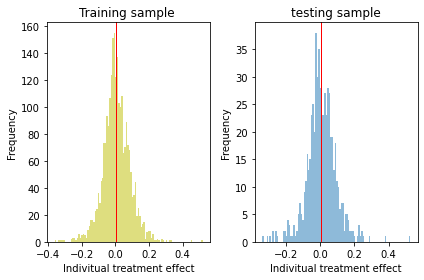

In [53]:
import matplotlib.pyplot as plt 

train_output = model(x_train).detach().cpu().numpy()
test_output = model(x_test).detach().cpu().numpy()

print("average tx effect", np.mean(train_output))
print("average tx effect", np.mean(test_output))

plt.subplot(1,2,1)
plt.hist(train_output, bins=100 ,alpha= 0.5, color="y")
plt.axvline(x= np.mean(train_output), linewidth=1, color='r')

plt.title("Training sample " )
plt.xlabel("Indivitual treatment effect")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(test_output,bins=100 , alpha = 0.5)
plt.axvline(x= np.mean(test_output), linewidth=1, color='r')

plt.title("testing sample")
plt.xlabel("Indivitual treatment effect")
plt.ylabel("Frequency")
plt.tight_layout()

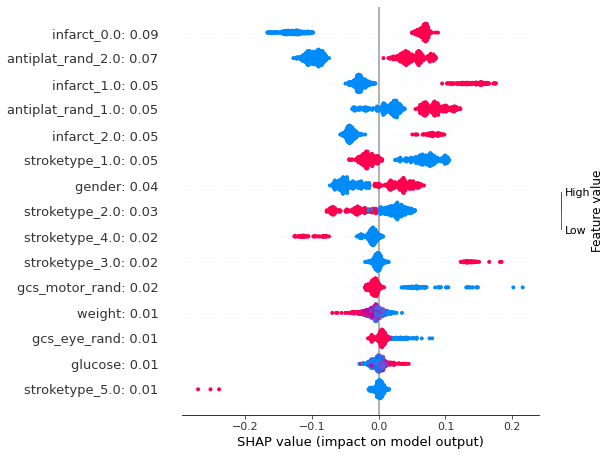

In [54]:
plot_feature_values(learner_explanations["shapley_sampling"])

In [ ]:
# Shapley value sampling
shapley_value_sampling_model = ShapleyValueSampling(model)

learner_explanations["shapley_sampling_0"] = shapley_value_sampling_model.attribute(
                                                 torch.from_numpy(x_test).to("cuda:1").requires_grad_(),
                                                n_samples=500,
                                                perturbations_per_eval=10,
                                            ).detach().cpu().numpy()

plot_feature_values(learner_explanations["shapley_sampling_0"])

In [ ]:
# Shapley value sampling
ig = IntegratedGradients(model)

learner_explanations["ig"] = ig.attribute(
                                    torch.from_numpy(x_test).to("cuda:1").requires_grad_(),
                                    n_steps=500,
                            ).detach().cpu().numpy()

plot_feature_values(learner_explanations["ig"])

In [4]:
cohort_name = "ist3"

trials = 5
top_n_features = 10
learner = "xlearner"

data = Dataset(cohort_name)
x_train, w_train, y_train = data.get_training_data()
x_test, w_test, y_test = data.get_training_data()
replacement_value = data.get_features_mins()

names = data.get_feature_names()

feature_size = x_train.shape[1]

device = "cuda:3"

learner_explanations = {}

models = {
    "xlearner":
        pseudo_outcome_nets.XLearner(  
        x_train.shape[1],
        binary_y=(len(np.unique(y_train)) == 2),
        n_layers_out=2,
        n_units_out=100,
        batch_size=128,
        n_iter=1500,
        nonlin="relu",
        device=device,
    ),
    "drlearner":
        pseudo_outcome_nets.DRLearner(  
        x_train.shape[1],
        binary_y=(len(np.unique(y_train)) == 2),
        n_layers_out=2,
        n_units_out=100,
        batch_size=128,
        n_iter=1500,
        nonlin="relu",
        device=device,
    )
}
explainers = [
    "ig", 
    "shapley_sampling_0", 
    "shap"
]

top_k_results = {
    "ig":[],
    "shapley_sampling_0":[],
    "shap":[]
    }

result_sign = {
    "ig": np.zeros((trials,feature_size)),
    "shapley_sampling_0": np.zeros((trials,feature_size)),
    "shap": np.zeros((trials,feature_size))
    }

results_train = np.zeros((trials, len(x_train)))
results_test = np.zeros((trials, len(x_test)))

#### Getting top n features from multiple runs. 

for i in range(trials):

    insertion_deletion_data = []

    model = models[learner]
    model.fit(x_train, y_train, w_train)

    results_train[i] = model(x_train).detach().cpu().numpy().flatten()
    results_test[i] = model(x_test).detach().cpu().numpy().flatten()

    ig = IntegratedGradients(model)

    print("==================================================")
    print("explaining with IG")

    learner_explanations["ig"] = ig.attribute(
                                        torch.from_numpy(x_test).to(device).requires_grad_(),
                                        n_steps=500,
                                ).detach().cpu().numpy()

    print("==================================================")
    print("explaining with shapley sampling -0")

    rank_indices = attribution_ranking(learner_explanations["ig"])

    insertion_results, deletion_results = attribution_insertion_deletion_no_mask(x_test,
                                           rank_indices,
                                           replacement_value,
                                           model
                                           )
    insertion_deletion_data.append(
        [
            "ig",
            insertion_results, 
            deletion_results
        ]
    )

    shapley_value_sampling_model = ShapleyValueSampling(model)
    learner_explanations["shapley_sampling_0"] = shapley_value_sampling_model.attribute(
                                                    torch.from_numpy(x_test).to(device).requires_grad_(),
                                                    n_samples=500,
                                                    perturbations_per_eval=10,
                                                ).detach().cpu().numpy()

    print("==================================================")
    print("explaining with shapley sampling - marginal distribution")

    rank_indices = attribution_ranking(learner_explanations["shapley_sampling_0"])

    insertion_results, deletion_results = attribution_insertion_deletion_no_mask(x_test,
                                           rank_indices,
                                           replacement_value,
                                           model
                                           )
    insertion_deletion_data.append(
        [
            "shapley_sampling_0",
            insertion_results, 
            deletion_results
        ]
    )
    marginal_extension = removal.MarginalExtension(x_test, model)
    shap_values = np.zeros((x_test.shape))

    for test_ind in range(len(x_test)):
        instance = x_test[test_ind]
        game = games.PredictionGame(marginal_extension, instance)
        explanation = shapley_sampling.ShapleySampling(game, thresh=0.01, batch_size=128)
        shap_values[test_ind] = explanation.values.reshape(-1, x_test.shape[1])

    learner_explanations["shap"] = shap_values

    rank_indices = attribution_ranking(learner_explanations["shap"])

    insertion_results, deletion_results = attribution_insertion_deletion_no_mask(x_test,
                                           rank_indices,
                                           replacement_value,
                                           model
                                           )

    insertion_deletion_data.append(
        [
            "shap",
            insertion_results, 
            deletion_results
        ]
    )

    with open( f"results/{cohort_name}/insertion_deletion_{learner}_{i}.pkl", "wb") as output_file:    
        pickle.dump(insertion_deletion_data, output_file)

    #### Getting top n features

    for e in explainers:
        ind = np.argpartition(np.abs(learner_explanations[e]).mean(0).round(2), -top_n_features)[-top_n_features:]
        top_k_results[e].extend(names[ind].tolist())

        for col in range(feature_size):
            result_sign[e][i, col] = stats.pearsonr(x_test[:,col], learner_explanations[e][:, col])[0]

for e in explainers:
    results = collections.Counter(top_k_results[e])
    summary = pd.DataFrame(results.items(), columns=['feature', 'count (%)']).sort_values(by="count (%)", ascending=False)
    summary["count (%)"] = np.round(summary["count (%)"]/trials,2)*100

    indices = [names.tolist().index(i) for i in summary.feature.tolist()]
    summary["sign"] = np.sign(np.mean(result_sign[e], axis=(0))[indices])

    summary.to_csv(f"results/{cohort_name}/{e}_top_{top_n_features}_features_{learner}.csv")

with open( f"results/{cohort_name}/train_{learner}.pkl", "wb") as output_file:    
    pickle.dump(results_train, output_file)

with open( f"results/{cohort_name}/test_{learner}.pkl", "wb") as output_file:    
    pickle.dump(results_test, output_file)


[po_estimator_0_impute_pos] Epoch: 0, current validation loss: 0.27700456976890564, train_loss: 0.31041598320007324
[po_estimator_0_impute_pos] Epoch: 50, current validation loss: 0.027806375175714493, train_loss: 0.016971692442893982
[po_estimator_0_impute_pos] Epoch: 100, current validation loss: 0.020027320832014084, train_loss: 0.006622212938964367
[po_estimator_0_impute_pos] Epoch: 150, current validation loss: 0.017219392582774162, train_loss: 0.006562903523445129
[po_estimator_0_impute_pos] Epoch: 200, current validation loss: 0.01706978678703308, train_loss: 0.006967932917177677
[po_estimator_1_impute_pos] Epoch: 0, current validation loss: 0.35028767585754395, train_loss: 0.4255410432815552
[po_estimator_1_impute_pos] Epoch: 50, current validation loss: 0.023664774373173714, train_loss: 0.015478557907044888
[po_estimator_1_impute_pos] Epoch: 100, current validation loss: 0.015027287416160107, train_loss: 0.0068418290466070175
[po_estimator_1_impute_pos] Epoch: 150, current val

 19%|███████▍                                | 0.1869/1 [00:08<00:36, 44.29s/it]

KeyboardInterrupt: 